c:\Users\Lupo\anaconda3\envs\cudaV2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Computing embedding for the new image: new_images/Food.jpg
Embedding computed.
Finding top similar images...
Top similar images: ['68e6461f-e771-4312-b901-d5990b8822b0', '1e8ba44b-27d6-4e08-b242-f11cbc353dde', '1f74fa41-7152-46cb-9a4b-21369fada5d3', 'b77795cf-dfbb-419b-a567-534811bc0a4e', '6a3f0d5d-ec6b-4854-a40c-f2d5fa99ec58']
Loading image paths from the database...
Image paths loaded: {'6a3f0d5d-ec6b-4854-a40c-f2d5fa99ec58': 'E:/data/image_data\\Fruits_Vegetables\\test\\eggplant\\Image_7.jpg', 'b77795cf-dfbb-419b-a567-534811bc0a4e': 'E:/data/image_data\\Fruits_Vegetables\\train\\eggplant\\Image_11.jpg', '1f74fa41-7152-46cb-9a4b-21369fada5d3': 'E:/data/image_data\\Fruits_Vegetables\\validation\\eggplant\\Image_7.jpg', '68e6461f-e771-4312-b901-d5990b8822b0': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000197867.jpg', '1e8ba44b-27d6-4e08-b242-f11cbc353dde': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000409304.jpg'}
Top similar images paths: ['E:/data/imag

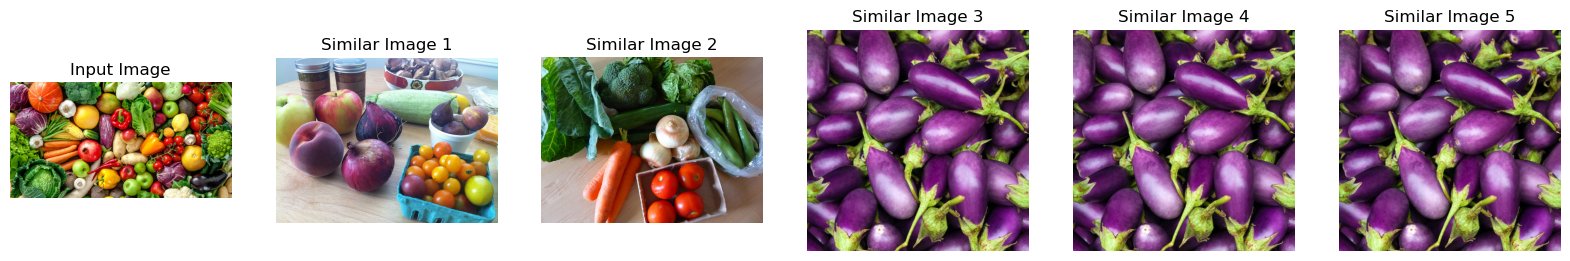

Images plotted.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pd.read_pickle(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def find_top_similar_images(embedding, embeddings_batches, top_n=5):
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity([embedding], embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_path, top_similar_images_paths):
    plt.figure(figsize=(20, 10))
    
    main_image = cv2.imread(main_image_path)
    if main_image is None:
        raise ValueError(f"Main image not found at path: {main_image_path}")
    main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(top_similar_images_paths) + 1, 1)
    plt.imshow(main_image)
    plt.title('Input Image')
    plt.axis('off')
    
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(top_similar_images_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')
    
    plt.show()

# Example usage
input_image_path = "new_images/Food.jpg"  # Path to the input image
cosine_similarities_path = "combined_embeddings.pkl"  # Path to precomputed dataset embeddings
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity

# Compute embedding for the new image
print(f"Computing embedding for the new image: {input_image_path}")
new_image_embedding = compute_embedding(input_image_path, model)
print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(cosine_similarities_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_image_path, top_similar_images_paths)
print("Images plotted.")


100%|██████████| 445/445 [00:01<00:00, 243.58it/s]


Top similar images using correlation method: ['d3fa60b4-cffc-467c-9e3b-74f9dcb3cec7', '4d2c1b51-72f9-44c0-bd2e-9ff0456c32ee', 'bd429c00-1ca1-44ff-9001-bb58fe7af37a', 'bda00d59-7345-445e-bf9d-db68f666ff57', '46f50811-a68e-4582-9f8d-36155e636c5e']


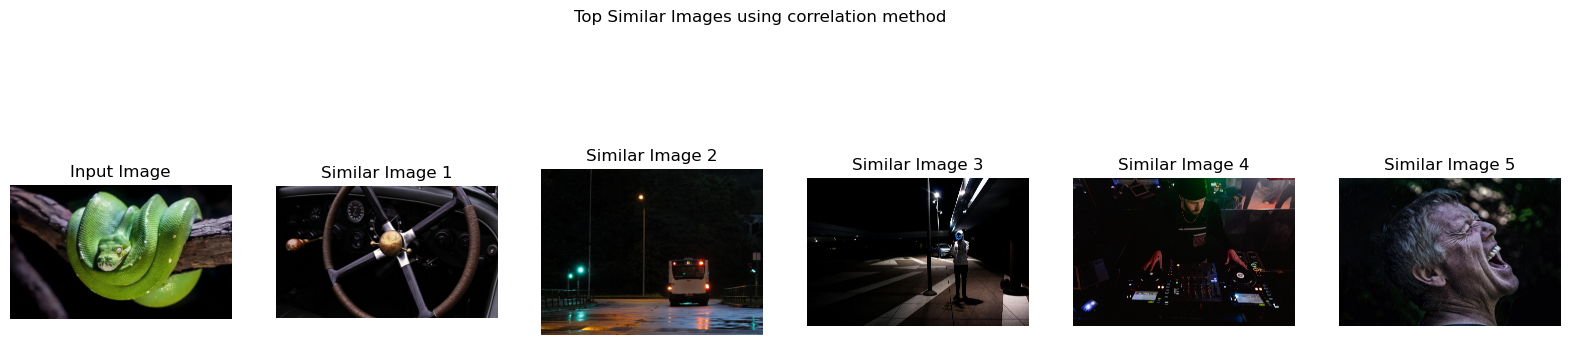

In [18]:
import os
import pickle
import sqlite3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the histograms from the pickle file
def load_histograms(pickle_file):
    with open(pickle_file, 'rb') as f:
        histograms = pickle.load(f)
    return histograms

# Compare histograms using different methods
def compare_histograms(hist1, hist2, method='correlation'):
    if hist1.shape != hist2.shape:
        raise ValueError("Histograms must have the same shape for comparison.")
    
    if method == 'correlation':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    elif method == 'chi-square':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    elif method == 'intersection':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    elif method == 'bhattacharyya':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

# Preprocess histogram to ensure consistent shape
def preprocess_histogram(hist, bin_size=(16, 16, 16), ranges=[0, 256, 0, 256, 0, 256]):
    hist = cv2.calcHist([hist], [0, 1, 2], None, bin_size, ranges)
    cv2.normalize(hist, hist)
    return hist.flatten()

# Find the top similar images
def find_top_color_similar_images(target_hist, histograms, top_n=5, method='correlation', batch_size=1000):
    all_uuids = list(histograms.keys())
    similarities = []

    # Process in batches
    for i in tqdm(range(0, len(all_uuids), batch_size)):
        batch_uuids = all_uuids[i:i+batch_size]
        batch_histograms = [histograms[uuid] for uuid in batch_uuids]
        batch_similarities = []
        for hist in batch_histograms:
            try:
                similarity = compare_histograms(target_hist, hist, method)
                batch_similarities.append(similarity)
            except ValueError as e:
                print(f"Error comparing histograms: {e}")
                batch_similarities.append(float('-inf') if method in ['correlation', 'intersection'] else float('inf'))
        similarities.extend(batch_similarities)

    # For 'correlation' and 'intersection', higher score means more similar; for others, lower score means more similar
    if method in ['correlation', 'intersection']:
        top_similar_indices = np.argsort(similarities)[-top_n:]
    else:
        top_similar_indices = np.argsort(similarities)[:top_n]
    
    top_similar_uuids = [all_uuids[idx] for idx in top_similar_indices]
    return top_similar_uuids

# Plot images
def plot_images(input_image_path, similar_image_paths, method):
    fig, axes = plt.subplots(1, len(similar_image_paths) + 1, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    for i, img_path in enumerate(similar_image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f'Similar Image {i+1}')
        axes[i+1].axis('off')

    plt.suptitle(f'Top Similar Images using {method} method')
    plt.show()

# Load image paths from the database
def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def main():
    pickle_file = "combined_color_histograms.pkl"  # Replace with your actual file path
    input_image_path = "new_images/try4.jpg"  # Replace with your actual input image path
    database_path = "image_metadata.db" 
    
    # Load the histograms from the pickle file
    histograms = load_histograms(pickle_file)

    # Compute the histogram for the input image
    input_image = cv2.imread(input_image_path)
    if input_image is None:
        raise ValueError(f"Unable to read image at path {input_image_path}")
    input_hist = preprocess_histogram(input_image)

    # Find top similar images for different methods
    methods = ['correlation']
    for method in methods:
        top_similar_uuids = find_top_color_similar_images(input_hist, histograms, top_n=5, method=method)
        image_paths_dict = load_image_paths_from_db(database_path, top_similar_uuids)
        top_similar_image_paths = [image_paths_dict[uuid] for uuid in top_similar_uuids]
        print(f"Top similar images using {method} method: {top_similar_uuids}")
        plot_images(input_image_path, top_similar_image_paths, method)

if __name__ == "__main__":
    main()
